In [1]:
import skvideo
skvideo.setFFmpegPath("C:\\src\\ffmpeg-4.2.2-win64-dev\\bin")
import skvideo.io
import itk
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from data_manager import *
from ocularus import *
filepath='../data/clarius phantom study-20200308/4mm/4mm-capture_1.mp4'
vid = skvideo.io.vread(filepath)[::,::,::,1].astype('float32')


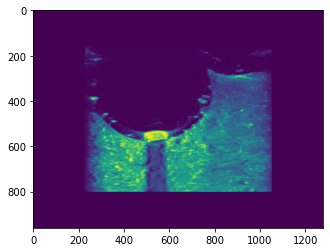

In [2]:
plt.imshow(vid[130])
img = itk.image_from_array(vid[130])

In [3]:
cropper = CropPreprocess(img, 0.05, 0.05)

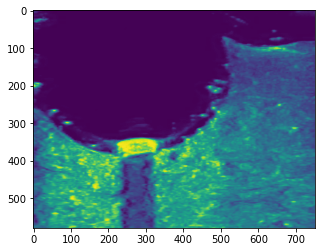

In [6]:
img_crop = cropper.crop(img)
plt.imshow(img_crop)

In [7]:
npimg2 = itk.array_from_image(img_crop)
img3 = image_from_array(npimg2, img_crop)

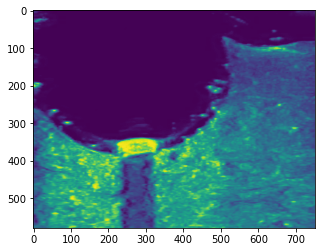

In [8]:
plt.imshow(img3)

In [9]:
from __future__ import print_function
cor = ClariusOfflineReader(filepath)
def foo(x):
    plt.imshow(cor.get(x))

interact(foo, x=widgets.IntSlider(min=0, max=cor.video.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='x', max=474), Output()), _dom_classes=('widget-interact'…

<function __main__.foo(x)>

In [10]:
cor = ClariusOfflineReader(filepath)
img = cor.get(130)


Here1:  itkVectorD2 ([0.0448865, 0.0448865])
Here2:  itkVectorD2 ([0.0448865, 0.0448865])
Here3:  itkVectorD2 ([0.0448865, 0.0448865])
Here4:  itkVectorD2 ([0.0448865, 0.0448865])
Here5:  itkVectorD2 ([0.0448865, 0.0448865])


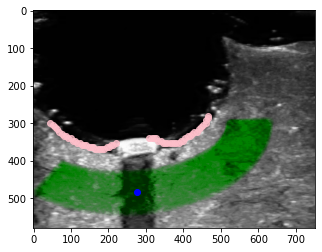

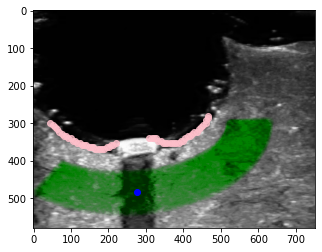

In [11]:
eyeseg = EyeSegmentationRANSAC()
img2 = cropper.crop(img)
eye = eyeseg.process(img2)
create_eye_figure(img2, eye)

invalid value encountered in true_divide


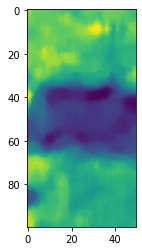

In [12]:
nerveseg = NerveSegmentationSkeleton()
nerve = nerveseg.process(img2, eye)

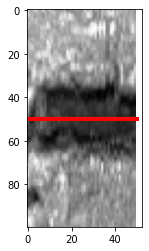

In [13]:
plt.imshow(nerve.nerve_image, cmap='gray')
plt.plot([0, nerve.nerve_image.shape[0]/2], [nerve.nerve_image.shape[1], nerve.nerve_image.shape[0]/2], color='red', linewidth=4)

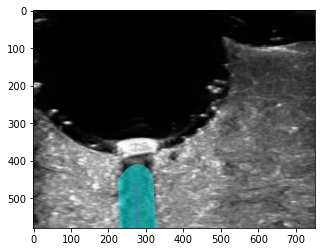

In [15]:
plt.imshow(overlay(itk.array_from_image(img2), [itk.array_from_image(nerve.nerve_mask), itk.array_from_image(nerve.skeleton_image)], [np.array([0, 1, 1]), np.array([1, 0, 1])], [0.5, 1]))

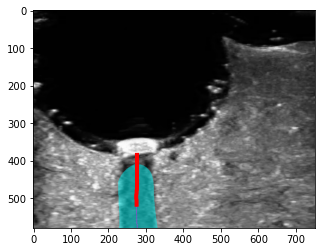

In [16]:
c, dist = nearest_curve(nerve.skeleton, eye.ellipse_model)
ts = np.linspace(-dist+nerveseg.nerve_offset,  nerveseg.nerve_image_dimension[0]-dist+nerveseg.nerve_offset, nerveseg.nerve_image_sampling[0]) # 6mm
ys = c.evaluate(ts)
plt.imshow(overlay(itk.array_from_image(img2), [itk.array_from_image(nerve.nerve_mask), itk.array_from_image(nerve.skeleton_image)], [np.array([0, 1, 1]), np.array([1, 0, 1])], [0.5, 1]))
idxs = transform_to_indices(ys, img2)
plt.plot(idxs[:,1], idxs[:,0], color='red', linewidth=4)

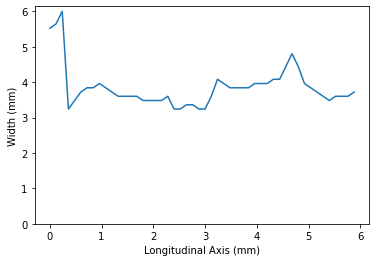

In [17]:

plt.plot(nerve.nerve_width[:,0], nerve.nerve_width[:,1])
plt.ylim(bottom=0)
plt.xlabel('Longitudinal Axis (mm)')
plt.ylabel('Width (mm)')
plt.savefig('WidthPlot.svg', dpi=1200)

In [12]:
import re
from glob import glob
import pickle
import pandas as pd
import numpy as np

# uncomment out below to run off of actual output
# due to size limitations, this needs to be recalculated
# use cmd-run.py to regenerate the output
# pattern = r'(?P<size_id>\d+)mm-capture_(?P<sample_id>\d+)-out'
# files = glob('*/width.p')
# tmp = []
# for fp in files:
#     size_id, sample_id = re.search(pattern, fp).group('size_id', 'sample_id')
#     with open(fp, 'rb') as f:
#         width = pickle.load(f)
#     tmp.append([int(size_id), sample_id, width])
# df = pd.DataFrame(tmp, columns=['size_id', 'sample_id', 'width'])

# otherwise, the measurements have been saved
df = pd.read_csv('../data/2020-MICCAI-ASMUS-output/output-summary.csv', dtype={'size_id':np.float64, 'width': np.float64, 'sample_id' : str})


In [13]:

print(df)

    Unnamed: 0  size_id sample_id     width
0            0      3.0         1  2.946000
1            1      3.0        10  2.685000
2            2      3.0         2  2.933333
3            3      3.0         3  3.090000
4            4      3.0         4  3.030000
5            5      3.0         5  2.934000
6            6      3.0         6  3.171429
7            7      3.0         7  2.868000
8            8      3.0         8  2.690000
9            9      3.0         9  2.688000
10          10      4.0         1  3.820000
11          11      4.0        10  3.997500
12          12      4.0         2  3.880000
13          13      4.0         3  4.035000
14          14      4.0         4  4.032000
15          15      4.0         5  3.891429
16          16      4.0         6  3.870000
17          17      4.0         7  3.711429
18          18      4.0         8  4.080000
19          19      4.0         9  3.980000
20          20      5.0         1  4.895000
21          21      5.0        1

In [15]:

df.groupby('size_id').mean()

,Unnamed: 0,width
size_id,,
3.0,4.5,2.903576
4.0,14.5,3.929736
5.0,24.5,4.477041
6.0,34.5,5.607794
7.0,44.5,6.432677


In [16]:
df.groupby('size_id').mad()


,Unnamed: 0,width
size_id,,
3.0,2.5,0.136661
4.0,2.5,0.095164
5.0,2.5,0.194966
6.0,2.5,0.077387
7.0,2.5,0.070982


In [30]:
# df3 = pd.DataFrame(tmp, columns=['size_id', 'sample_id', 'best_width'])
# df3['size_id'] = df3['size_id'].astype('float32')
# plt.scatter(df3['size_id'], df3['best_width'])

df3 = pd.read_csv('../data/2020-MICCAI-ASMUS-output/best-frames.csv', dtype={'size_id':np.float64, 'best_width': np.float64, 'sample_id' : str})

0.9794456732161966
predict_stdev: 0.20
0.9765738302044928
predict_stdev: 0.22


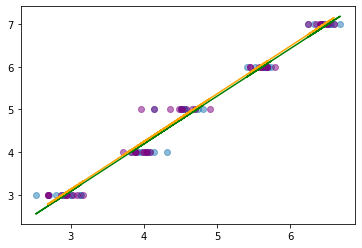

In [31]:
from sklearn.linear_model import LinearRegression
reg3 = LinearRegression().fit(df3[['best_width']], df3['size_id'])
print(reg3.score(df3[['best_width']], df3['size_id']))
# X = np.linspace(np.min(df['size_id']), np.max(df['size_id']))
Y = reg3.predict(df3['best_width'][:,np.newaxis])
predict_stdev = np.std(df3['size_id'] - Y)

print('predict_stdev: {:.2f}'.format(predict_stdev))
plt.plot(df3['best_width'], Y, color='green')
plt.scatter(df3['best_width'], df3['size_id'], alpha=0.5)
plt.scatter(df['width'], df['size_id'], color='purple', alpha=0.5)

reg = LinearRegression().fit(df[['width']], df['size_id'])
print(reg.score(df[['width']], df['size_id']))
Y = reg.predict(df['width'][:,np.newaxis])
predict_stdev = np.std(df['size_id'] - Y)
# predict_stdev = np.sqrt(sum_squares/(len(Y) - 1))
plt.plot(df['width'], Y, color='orange')
print('predict_stdev: {:.2f}'.format(predict_stdev))

0.9765738302044928
predict_stdev: 0.22


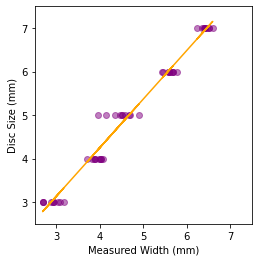

In [32]:
reg = LinearRegression().fit(df[['width']], df['size_id'])
print(reg.score(df[['width']], df['size_id']))
Y = reg.predict(df['width'][:,np.newaxis])
predict_stdev = np.std(df['size_id'] - Y)
# predict_stdev = np.sqrt(sum_squares/(len(Y) - 1))

fig, ax = plt.subplots()
ax.scatter(df['width'], df['size_id'], color='purple', alpha=0.5)
ax.plot(df['width'], Y, color='orange')
plt.xlim(left=2.5, right=7.5)
plt.ylim(bottom=2.5, top=7.5)
ax.set_aspect('equal', adjustable='box')
plt.xlabel('Measured Width (mm)')
plt.ylabel('Disc Size (mm)')
plt.savefig('Regression.svg')
print('predict_stdev: {:.2f}'.format(predict_stdev))